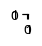

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *
exp_df = pd.read_csv('../data/filtered/240326_nettcr_paired_NOswaps.csv')
top17 = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv').peptide.unique()
exp17 = exp_df.query('peptide in @top17')

In [60]:
%ls ../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_N1jMC/ | grep "4500\|JSON"

checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_N1jMC_JSON_kwargs.json
epoch_4500_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_N1jMC.pt


In [61]:
tsnotrp = load_model_full('epoch_4500_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_N1jMC.pt',
                          'checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_N1jMC_JSON_kwargs.json',
                          dir_path='../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_N1jMC/')


<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
epoch: 4500
total: 0.7775099739190969
reconstruction: 0.24511546373418122
kld: 0.0
triplet: 0.0
BCE: 0.5323945055735589
seq_accuracy: 0.9910694360733032
pos_accuracy: 0.9997903108596802
auc: 0.7436
auc_01: 0.59057
auc_01_real: 0.22208
precision: 0.39935
recall: 0.43906
accuracy: 0.79582
AP: 0.35665


In [2]:

tscstrp = load_model_full('epoch_4500_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd.pt',
                          'checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd_JSON_kwargs.json',
                          dir_path='../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd')

# Apparently I need to remake ALL these FUCKING 17peps stupid bullshit
t17 = exp17.query('partition==1')
pep17 = exp17.peptide.unique()
# Get latent
latent_tscstrp_t17 = get_latent_df(tscstrp, t17)
# get vae dms
dm_tscstrp_t17 = make_dist_matrix(latent_tscstrp_t17, cols=('raw_index','peptide','partition','binder'))
# Read benchmarks
tcrbase = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv')
# filter benchmarks
dm_tcrbase_t17, _ = resort_baseline(tcrbase, dm_tscstrp_t17, 'raw_index')
# Do 4 distance matrices : OSNOTRP, TSCSTRP, TCRBase, tcrdist3

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
epoch: 4500
total: 0.28910083712824164
reconstruction: 0.05983970926761729
kld: 0.0
triplet: 0.0
BCE: 0.22926112741663837
seq_accuracy: 0.9946567416191101
pos_accuracy: 0.9978268146514893
auc: 0.73856
auc_01: 0.57302
auc_01_real: 0.18874
precision: 0.40048
recall: 0.42172
accuracy: 0.79778
AP: 0.34001


In [25]:
# Remake those agglo and kmeans threshold functions here to also log n_above:
from src.cluster_utils import *

def agglo_single_threshold(dist_array, features, labels, encoded_labels, label_encoder, threshold,
                           min_purity=0.8, min_size=6,
                             silhouette_aggregation='micro', return_df_and_c=False):
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=threshold, linkage='complete')
    c.fit(dist_array)
    if return_df_and_c:
        return *get_all_metrics(threshold, dist_array, c, dist_array, labels, encoded_labels, label_encoder, silhouette_aggregation,
                                min_purity=min_purity, min_size=min_size,
                                return_df=return_df_and_c), c
    else:
        return get_all_metrics(threshold, dist_array, c, dist_array, labels, encoded_labels, label_encoder, silhouette_aggregation,
                               min_purity=min_purity, min_size=min_size)


# Here, do a run ith only the best
def agglo_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder, decimals=5, n_points=500,
                         min_purity=0.8, min_size=6,
                           silhouette_aggregation='micro', n_jobs=1):
    # Getting clustering at all thresholds
    limits = get_linspace(dist_array, decimals, n_points)
    if n_jobs > 1 or n_jobs==-1:
        wrapper = partial(agglo_single_threshold, dist_array=dist_array, features=features, labels=labels,
                          min_purity=min_purity, min_size=min_size,
                          encoded_labels=encoded_labels, label_encoder=label_encoder, silhouette_aggregation=silhouette_aggregation)
        results = Parallel(n_jobs=n_jobs)(delayed(wrapper)(threshold=t) for t in tqdm(limits))
    else:
        results = []
        for t in tqdm(limits):
            results.append(agglo_single_threshold(dist_array, features, labels, encoded_labels, label_encoder, t, 
                                                  silhouette_aggregation=silhouette_aggregation, min_purity=min_purity, min_size=min_size))
    results = pd.DataFrame(results).sort_values('threshold')
    results['retention'] = (dist_array.shape[0] - results['n_singletons']) / dist_array.shape[0]
    return results

def agglo_pipe(matrix, min_purity=0.8, min_size=6, silhouette_aggregation='micro',
               decimals=5, n_points=500, n_jobs=-1):
    da = matrix.iloc[:len(matrix), :len(matrix)].values
    labels = matrix['peptide'].values
    labenc = LabelEncoder()
    encoded_labels = labenc.fit_transform(labels)
    results = agglo_all_thresholds(da, da, labels, encoded_labels, labenc, decimals, n_points, min_purity, min_size, 
                                   silhouette_aggregation, n_jobs)
    results['best'] = False
    results.loc[results['silhouette'].idxmax(), 'best']=True
    return results[['threshold', 'silhouette', 'best', 'n_cluster', 'n_singletons', 'mean_purity', 'min_purity', 'max_purity','mean_cluster_size', 'min_cluster_size','max_cluster_size', 'n_above', 'retention']]

best_vae = agglo_pipe(dm_tscstrp_t17, 0.8, 6)#.query('best')
best_tcrbase = agglo_pipe(dm_tcrbase_t17, 0.8, 6)#.query('best')
display(best_vae.query('best'))
display(best_tcrbase.query('best'))

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

,threshold,silhouette,best,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_cluster_size,min_cluster_size,max_cluster_size,n_above,retention
233,0.66461,0.144,True,480,75,0.602301,0.2,1.0,2.90625,2.0,18.0,17,0.94898


,threshold,silhouette,best,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_cluster_size,min_cluster_size,max_cluster_size,n_above,retention
463,0.31076,0.2003,True,2,0,0.191001,0.15978,0.222222,735.0,18.0,1452.0,0,1.0


,threshold,silhouette,best,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_cluster_size,min_cluster_size,max_cluster_size,n_above,retention
463,0.31076,0.2003,True,2,0,0.191001,0.15978,0.222222,735.0,18.0,1452.0,0,1.0


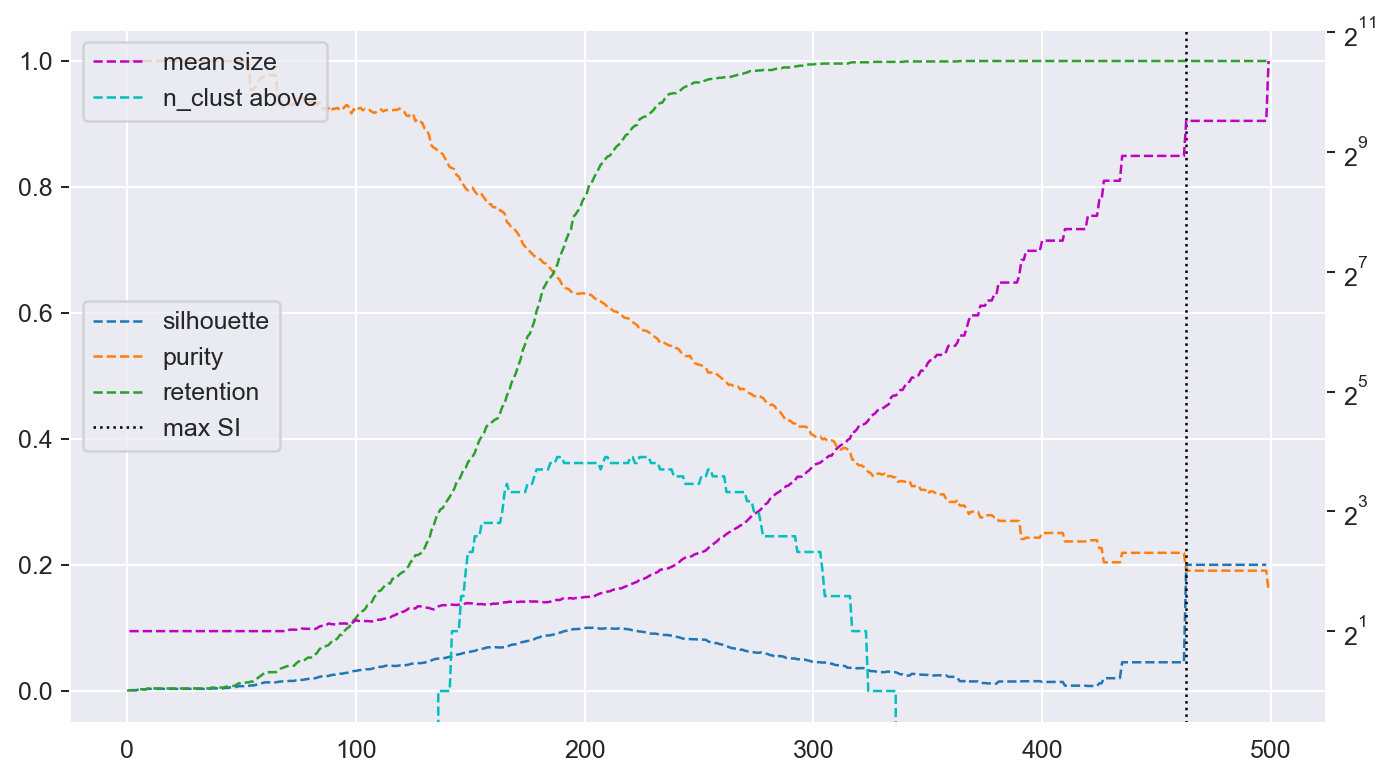

In [26]:
plot_sprm(best_tcrbase)

In [55]:
def pipe_single(matrix, threshold, min_purity=0.8, min_size=6, silhouette_aggregation='micro'):
    da = matrix.iloc[:len(matrix), :len(matrix)].values
    labels = matrix['peptide'].values
    labenc = LabelEncoder()
    encoded_labels = labenc.fit_transform(labels)
    results= agglo_single_threshold(da, da, labels, encoded_labels, labenc, threshold, min_purity, min_size, 
                                   silhouette_aggregation, return_df_and_c = True)
    return results[0], results[1]
a,b = pipe_single(dm_tscstrp_t17, 0.66461, 0.8, 7)

In [21]:
c,d = pipe_single(dm_tcrbase_t17, 0.31076, 0.8, 7)

In [24]:
d.query('purity>0.7 and cluster_size>7')

,pred_label,purity,coherence,cluster_size,majority_label


In [30]:
b.query('cluster_size>5')[['purity','cluster_size','majority_label']]

,purity,cluster_size,majority_label
9,0.777778,9,CINGVCWTV
21,0.857143,7,GILGFVFTL
29,0.714286,7,LLWNGPMAV
31,1.000000,10,GILGFVFTL
44,0.200000,10,RAKFKQLL
53,0.428571,7,ELAGIGILTV
61,0.500000,6,ELAGIGILTV
63,0.941176,17,IVTDFSVIK
73,0.857143,7,LLWNGPMAV
80,0.833333,6,TTDPSFLGRY


# what is going on

In [36]:
path='../output/240911_RedoTwoStageOnly_MST_cut_francis_garner_subsampled_NoDistMatrix/240911_101457_subsampled_francis_000_seed_003_MST_Redo_2TwoStages_subsampling_oCdtz'
%ls $path

TBCRalignsubsampled_francis_000_seed_003_silhouette.png
VAE_TS_CsTRPsubsampled_francis_000_seed_003_silhouette.png
VAE_TS_NoTRPsubsampled_francis_000_seed_003_silhouette.png
args_subsampled_francis_000_seed_003_KFold_NoKF_240911_1015_clstr.txt
cluster_results_TBCRalign_agglo.csv
cluster_results_TBCRalign_size_cut.csv
cluster_results_TBCRalign_topn_cut.csv
cluster_results_VAE_TS_CsTRP_agglo.csv
cluster_results_VAE_TS_CsTRP_size_cut.csv
cluster_results_VAE_TS_CsTRP_topn_cut.csv
cluster_results_VAE_TS_NoTRP_agglo.csv
cluster_results_VAE_TS_NoTRP_size_cut.csv
cluster_results_VAE_TS_NoTRP_topn_cut.csv
cluster_results_tcrdist3_agglo.csv
cluster_results_tcrdist3_size_cut.csv
cluster_results_tcrdist3_topn_cut.csv
result_TBCRalign_agglo.pkl
result_TBCRalign_size_cut.pkl
result_TBCRalign_topn_cut.pkl
result_VAE_TS_CsTRP_agglo.pkl
result_VAE_TS_CsTRP_size_cut.pkl
result_VAE_TS_CsTRP_topn_cut.pkl
result_VAE_TS_NoTRP_agglo.pkl
result_VAE_TS_NoTRP_size_cut.pkl
result_VAE_TS_NoTRP_topn_cut.pkl
result

In [43]:
xd=pkl_load(f'{path}/result_VAE_TS_CsTRP_topn_cut.pkl')
xd['purities'][np.array(xd['scores']).argmax()],xd['retentions'][np.array(xd['scores']).argmax()]

(0.8972222222222221, 0.7988)

In [47]:
len(xd['clusters'])

120

In [62]:
mixed_000_000 = pd.read_csv('../data/OTS/subsampled_covid_healthy_lowcount/subsampled_francis_000_seed_000.txt')
mixed_000_000
latent_tscstrp_mixed = get_latent_df(tscstrp, mixed_000_000)
# get vae dms
dm_tscstrp_mixed = make_dist_matrix(latent_tscstrp_mixed, cols=('Run','index_col','duplicated','mean_count','Subject','Disease','Source'))
# Read benchmarks

latent_tsnotrp_mixed = get_latent_df(tsnotrp, mixed_000_000)
# get vae dms
dm_tsnotrp_mixed = make_dist_matrix(latent_tsnotrp_mixed, cols=('Run','index_col','duplicated','mean_count','Subject','Disease','Source'))
# Read benchmarks


In [63]:
dm_tscstrp_mixed['peptide']=dm_tscstrp_mixed['Disease']
mixed_results_cs = agglo_pipe(dm_tscstrp_mixed)
mixed_results_cs.query('best')

  0%|          | 0/500 [00:00<?, ?it/s]

,threshold,silhouette,best,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_cluster_size,min_cluster_size,max_cluster_size,n_above,retention
397,1.12645,0.1364,True,20,0,0.756078,0.5,1.0,16.4,5.0,104.0,8,1.0


In [56]:
mixed_a, mixed_b = pipe_single(dm_tscstrp_mixed, 1.12645)
mixed_b

,pred_label,purity,coherence,cluster_size,majority_label
0,0,0.777778,0.859223,18,covid
1,1,0.866667,0.883427,15,covid
2,2,0.611111,0.825578,18,covid
3,3,0.900000,0.817447,10,covid
4,4,0.571429,0.849345,14,healthy
5,5,0.666667,0.849253,18,covid
6,6,0.875000,0.809707,8,covid
7,7,0.500000,0.829785,8,covid
8,8,0.833333,0.839764,12,covid
9,9,0.951923,0.578456,104,healthy


In [64]:
dm_tsnotrp_mixed['peptide']=dm_tsnotrp_mixed['Disease']
mixed_results_no = agglo_pipe(dm_tsnotrp_mixed)
mixed_results_no.query('best')

  0%|          | 0/500 [00:00<?, ?it/s]

,threshold,silhouette,best,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_cluster_size,min_cluster_size,max_cluster_size,n_above,retention
269,0.76668,0.1446,True,80,1,0.848709,0.5,1.0,4.0875,2.0,40.0,5,0.996951


In [69]:
mixed_a

{'threshold': 1.12645,
 'n_cluster': 20,
 'n_singletons': 0,
 'n_cluster_over_70p': 12,
 'mean_purity': 0.7560782273282274,
 'min_purity': 0.5,
 'max_purity': 1.0,
 'mean_coherence': 0.8071392,
 'min_coherence': 0.57845587,
 'max_coherence': 0.88342655,
 'mean_cluster_size': 16.4,
 'min_cluster_size': 5,
 'max_cluster_size': 104,
 'silhouette': 0.1364,
 'n_above': 8,
 'ch_index': 23.446556117219767,
 'db_index': 2.6593376321586026,
 'ARI': 0.17465567786587607}

In [68]:
mixed_c

{'threshold': 0.76668,
 'n_cluster': 80,
 'n_singletons': 1,
 'n_cluster_over_70p': 57,
 'mean_purity': 0.8487086038961038,
 'min_purity': 0.5,
 'max_purity': 1.0,
 'mean_coherence': 0.5821892,
 'min_coherence': 0.36859334,
 'max_coherence': 0.72662246,
 'mean_cluster_size': 4.0875,
 'min_cluster_size': 2,
 'max_cluster_size': 40,
 'silhouette': 0.1446,
 'n_above': 5,
 'ch_index': 14.122131052157684,
 'db_index': 1.4780909537575402,
 'ARI': 0.04696126340841106}

In [66]:
mixed_c, mixed_d = pipe_single(dm_tsnotrp_mixed, 0.76668)
mixed_d
mixed_d.sort_values('cluster_size',ascending=False)

,pred_label,purity,coherence,cluster_size,majority_label
6,6,0.900000,0.410245,40,healthy
41,41,1.000000,0.432581,29,healthy
72,72,0.960000,0.368593,25,healthy
9,9,0.727273,0.546125,11,healthy
13,13,0.727273,0.600681,11,covid
...,...,...,...,...,...
49,49,1.000000,0.501342,2,healthy
50,50,1.000000,0.605706,2,covid
53,53,1.000000,0.599664,2,covid
31,31,1.000000,0.582502,2,covid


In [44]:
pkl_load(f'{path}/result_VAE_TS_CsTRP_agglo.pkl')['best']

threshold               1.089150
n_cluster              22.000000
n_singletons            0.000000
n_cluster_over_70p     14.000000
mean_purity             0.790440
min_purity              0.538462
max_purity              1.000000
mean_coherence          0.799049
min_coherence           0.555025
max_coherence           0.892324
mean_cluster_size      14.909091
min_cluster_size        6.000000
max_cluster_size      122.000000
silhouette              0.159369
ch_index               28.524706
db_index                2.587915
ARI                     0.246608
retention               1.000000
Name: 222, dtype: float64

In [45]:
pkl_load(f'{path}/result_TBCRalign_agglo.pkl')['best']

threshold               0.260610
n_cluster               2.000000
n_singletons            0.000000
n_cluster_over_70p      1.000000
mean_purity             0.697657
min_purity              0.628959
max_purity              0.766355
mean_coherence          0.173391
min_coherence           0.156356
max_coherence           0.190426
mean_cluster_size     164.000000
min_cluster_size      107.000000
max_cluster_size      221.000000
silhouette              0.118660
ch_index              116.671033
db_index                1.414256
ARI                     0.118428
retention               1.000000
Name: 281, dtype: float64